# Optimal Estimation for Satellite Observations

## pyOpEst + RTTOV: Using RTTOV's K model Jacobians

This notebook shows step by step an a practical example of how to setup [pyOpEst](https://github.com/maahn/pyOptimalEstimation) together with [RTTOV](https://nwp-saf.eumetsat.int/site/software/rttov/), specifically we use RTTOV's Python wrapper. The structure of this notebook tries to follow the [examples](https://github.com/maahn/pyOptimalEstimation_examples) on how to use pyOpEst.

Our example takes available data from [NWPSAF](https://nwp-saf.eumetsat.int/site/software/atmospheric-profile-data2/), specifically the 137 levels dataset (you can find the compiled NETCDF example dataset in /data/nwpsaf.tar.xz). We will use such dataset to generate *synthetic observations* and *apriori data* (mean and covariance matrices); the example will use a simple K-Fold [cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) to test the retrieval. Cross validation can be used to tune different parameters of the retrieval chain (e.g. channels used, constrains, etc.), a sort of [hyperparameters tunning](https://www.youtube.com/watch?v=wKkcBPp3F1Y&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=26).

We start by importing some standard Python/Scipy/Pangeo packages that we use through out the example:

In [1]:
import os
import sys
import xarray as xr
import numpy as np
import datetime 
import time
from datetime import datetime 

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import pandas as pd

from sklearn.metrics import median_absolute_error, mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER



import pyOptimalEstimation as pyOE

Next we append the 'support' directory where we keep some support routines ('supporting_routines_m'). Here we also set and append the directory where our RTTOV wrapper ('pyrttov') is installed and finally we import it.

In [2]:
sys.path.append('support')

import supporting_routines_m 

# RTTOV's installation directories:

rttov_installdir = '/home/mario/myLibs/rrtov13/rttov130'
sys.path.append(rttov_installdir+'/wrapper')
import pyrttov

%matplotlib inline

The data used in this example are atmospherical states at different times of the year in different geographical locations (i.e. lat,lon combinations); among others, the atmospherical state contains temperature profile, humidity profile, near surface wind speed, etc. I use the data in a split fashion to both get *apriori* data (mean and covariance matrix) and generate syntethic observations (i.e. we take an atmospherical state, give it as input to RTTOV and get simulated temperature brightness). 

The dataset and documentation used in this example can be found here [NWPSAF](https://nwp-saf.eumetsat.int/site/software/atmospheric-profile-data2/); in there the data can be found in a specific format to be read in FORTRAN (routines are provided).  

For simplicity in this example, I have extracted a subset of the data points (i.e. only over the ocean) from all of the 5 subsets present in the dataset (see [NWPSAF documentation](https://nwp-saf.eumetsat.int/site/download/documentation/rtm/nwpsaf-ec-tr-017.pdf)) and wrote it into a NETCDF format that can be found in this repo. Finally I use Xarray to load the dataset.

In [3]:
aprio_dir = '/home/mario/Data/RadEst_crossVal_data/crossVal_aprioriData/'
prior_all = xr.open_dataset(aprio_dir+'nwpsaf.nc') 
prior_all

<xarray.Dataset>
Dimensions:           (height: 137, index: 16459)
Coordinates:
  * index             (index) int32 1 2 3 4 5 ... 16455 16456 16457 16458 16459
  * height            (height) float32 7.93e+04 7.372e+04 ... 30.96 10.0
Data variables: (12/15)
    Temperature       (height, index) float32 ...
    Humidity          (height, index) float32 ...
    Pressure          (height, index) float32 ...
    CLW               (height, index) float32 ...
    Rain              (height, index) float32 ...
    surfPressure      (index) float32 ...
    ...                ...
    U10               (index) float32 ...
    V10               (index) float32 ...
    W10               (index) float32 ...
    lat               (index) float32 ...
    long              (index) float32 ...
    Time              (index) int32 ...
Attributes:
    global_attribute:  Diverse profile datasets from the ECMWF 137-level shor...
    description:       Contains five subsets included in the original databas...
    author:            NWPSAF
    website:           https://nwp-saf.eumetsat.int/site/software/atmospheric...
    extra_info:        This simplified NETCDF dataset has been compiled in Se...

I decided to keep things simple, so I defined only two coordinates, whose description can be found in the attributes of the *.nc*: *index* and *height*. The *index* dimension (or coordinate, same in this case) simple encodes time, latitude and longitude; the *height* dimension contains the levels for the variables that are defined in a discrete vertical profile. All variables are *index* dependent whereas only profile variables (e.g. temperature profile, pressure profile, etc.) depend on the *height*. Non profile variables are surface variables. For a complete description check [NWPSAF documentation](https://nwp-saf.eumetsat.int/site/download/documentation/rtm/nwpsaf-ec-tr-017.pdf).

Next we can define some settings for using in RTTOV. Lets take a moment to talk about how do we use RTTOV in our example. 
RTTOV is our forward solver of choice, it maps atmospherical states (state space) into temperature brightness (observations space). RTTOV has the capability to simulate the forward response for a given sensor (e.g. SSMIS on F16, etc.) for 1, 2 or many atmospherical states in a single call. 
In general forward solvers can also compute the Jacobian matrix (used heavily during the retrievals); this is most of the time the most efficient way to obtain the Jacobians. 

In order to be able to call RTTOV as our forward operator, we need to define the number of levels in which vertical profiles are discretized (*nlevels*) and how many profiles (or atmospherical states) we want to simulate at the time; since we are performing an iterative optimization, we will use 1 profile only (*nprofiles*). 

In [4]:
nlevels = len(prior_all['height'])
nprofiles = 1

We create an instance of RTTOV; this object contains all data structures and methods needed to perform a forward simulation

In [5]:
ssmiRttov = pyrttov.Rttov()

Every instrument that RTTOV can simulate is represented in terms of a set of coefficients that need to be loaded (these are included in the package and can also be downloaded from the NWPSAF website) For Microwave channels, the 7th version with 54 Levels is used. We use the SSMIS on platform F16 as an example, for which we load the mentioned coefficients.

In [6]:
# SSMIS:
ssmiRttov.FileCoef = '{}/{}'.format(rttov_installdir,
                                    "rtcoef_rttov13/rttov7pred54L/rtcoef_dmsp_16_ssmis.dat")

RTTOV comes with a lot of possible settings, which you can easily set via the instance we have created: 

In [25]:
# We set the different options for the simulation,
# You can find the detailed description of the options
# on RTTOV documentation.

ssmiRttov.Options.AddInterp = True
#ssmiRttov.Options.InterpMode = 4
ssmiRttov.Options.CO2Data = False
ssmiRttov.Options.VerboseWrapper = False
ssmiRttov.Options.DoCheckinput = False
ssmiRttov.Options.UseQ2m = False
ssmiRttov.Options.ApplyRegLimits = True
ssmiRttov.Options.Verbose = False
ssmiRttov.Options.Switchrad = True
ssmiRttov.Options.FastemVersion = 6 
ssmiRttov.Options.Nthreads = 2

Having set the instrument coefficients and RTTOV options we can load the instrument to the RTTOV instance we created; at this point we can also set the list of channels that we want to load. This is optional and you can also load the instrument without specifying channels: *loadInst()*; this will load all available channels instead.


In [8]:
# Channels corrispondence:

# from: D. B. Kunkee et al, "Design and Evaluation of the First 
# Special Sensor Microwave Imager/Sounder", IEEE Trans. Geosc. Rem. Sens. 
# Vol. 46, NO. 4, April 2008.
# Table 1
# Ch. 12 - 19.35 GHz Hpol
# Ch. 13 - 19.35 GHz Vpol
# Ch. 14 - 22.235 GHz Vpol
# Ch. 15 - 37 GHz Hpol
# Ch. 16 - 37 GHz Vpol

chan_list_ssmi = (12,13,14,15,16)
nchan_ssmi = len(chan_list_ssmi)

# After the options are set we load the instrument:
try:
    ssmiRttov.loadInst(chan_list_ssmi)
except pyrttov.RttovError as e:
    sys.stderr.write("Error loading instrument(s): {!s}".format(e))
    sys.exit(1)

Definition of the observation variables. This is used for pyOpEst to idenfy the channels in input; this is more an identifier rather than a value. You can call your channels the way you prefer (please check [pyOpEst documetation](https://pyoptimalestimation.readthedocs.io/en/latest/) for more on this)

In [9]:
y_vars = np.array(chan_list_ssmi)

We now set the observation error covariance matrix; for our simplified example using SSMIS, we define a diagonal observation error covariance using values found in the bibliography. We use a Pandas DataFrame to keep this matrix. Here we simply followed pyOpEst examples.

In [10]:
# The instrument error covariance is taken for this example from
# Deblonde-English 2003

# This is instrument dependent and the values here are not a guarantee
# of fidelity with the actual instrument; they were taken from
# a well know reference and are used here just for the purposes
# of this tutorial. Any question on those values should be directed
# to the authors of the mentioned paper.


# Channels 1-7, 12-16, 23, 24 (values from Deblonde-English 2003) (sigma or std)
y_noise = pd.Series(
    [
        #1.5, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 2.4, 1.27, 1.44, 3.0, 1.34, 0.46, 0.47
        2.4, 1.27, 1.44, 3.0, 1.34
   ],
    index=y_vars
)

# Variance values > std**2
S_y = pd.DataFrame(
    np.diag(y_noise.values**2),
    index=y_vars,
    columns=y_vars,
)

Definition of the indices of the "local prior": we will call local prior to the prior built
using a geographical area "nearby" the observation location (i.e. a bounding box around the observation location).  
All the atmospheric states within such a box define our a-priori knowledge (in the spatial domain)

The user can modify this bounding box and play a bit with the results. Here the lower cap of the planet is used for the example:

In [11]:
lat_min = -90.0
lat_max = -40.0
long_min = -180.0
long_max = 180.0

Create simplified mask array: only points within bounding box will be selected

In [12]:
lat_long_mask = np.array([(prior_all['lat'].values[:]>lat_min)&(
                             prior_all['lat'].values[:]<lat_max)&
                           ((prior_all['long'].values[:]>long_min)&(
                               prior_all['long'].values[:]<long_max))])
lat_long_mask=lat_long_mask.reshape(-1)

Xarray has much better ways to deal with masking arrays (e.g. xarray.where or dataarray.where) I encourage the reader to check them out; for now I simply mask out by indexing:

In [13]:
# Creating a time index for the local prior:
times1 = prior_all['Time'].values[lat_long_mask]

# Creating lat, long vectors for auxiliary plots e.g. cartopy
lat = prior_all['lat'].values[lat_long_mask]
long = prior_all['long'].values[lat_long_mask]

Time in the original dataset is given in terms of a timestamp, i.e. seconds since a date in the 70's. So, I map that integer value in second to a datetime date:

In [14]:
time_index = np.zeros(len(times1),dtype='datetime64[s]')
for i in range(len(times1)):
    time_index[i] = supporting_routines_m.timestamp2datetime(times1[i])

Next we simply create a "local" dataset containing data only within the latitude-longitude bounding box that we want to work with:

**A VERY IMPORTANT REMARK: Inside the maskPrior routine we are changing the units of the humidity data from kg/kg to g/kg**

In [15]:
# Creating a "local" prior: Subset of "prior_all" 
# that contains only the selected lat,long area.

# Units of humidity change inside maskPrior: kg/kg => g/kg

prior_local = supporting_routines_m.maskPrior(
                     prior_all, time_index, lat_long_mask)

In [16]:
# Transform the humidity profiles to a logarithmic scale
# in order to improve their normality 

# IMPORTANT NOTE:
# RTTOV ACCEPTS ONLY kg / kg (LINEAR SCALE)
# THERE IS A LOG2LIN CONVERSION IN THE DEFINITION
# OF THE FORWARD OPERATOR; BUT INSIDE THE OPTIMAL
# ESTIMATION, THE HUMIDITY IS IN LOG SCALE

prior_local['Humidity'] = np.log10(prior_local['Humidity'])

Now we define some functions that will help "unclutter" our main loop:

In [17]:
# Self-explanatory:
def reshape4profiles(profiles):
    # "profiles" is a numpy array
    # "profiles" can contain 1 or more profiles
    # "profiles" has dimensions (nlevels, nprofiles)
    # "outProfiles" has dimensions (nprofiles,nlevels) (as needed in RTTOV)
    
    if (len(profiles.shape)==1):
        outProfiles = profiles.reshape(1,profiles.shape[0]).copy()
    else:
        outProfiles = profiles.T.copy() 
        
    return outProfiles   

During retrievals, the forward model uses both state vector {x} and parameters {b}, see:

Maahn, M., D. D. Turner, U. Löhnert, 
D. J. Posselt, K. Ebell, G. G. Mace, and 
J. M. Comstock, 2020: 
Optimal Estimation Retrievals and Their Uncertainties: 
What Every Atmospheric Scientist Should Know. 
Bull. Amer. Meteor. Soc., 
doi:https://doi.org/10.1175/BAMS-D-19-0027.1 [here](https://doi.org/10.1175/BAMS-D-19-0027.1)

However the forward model also requires other "parameters" to be initialized, "parameters" that we assume as "ground truth" or simply that need to be initialized:

Examples of these in our tutorial: date, pressure profile, latitude, longitude, incidence angle (zenith angle) and salinity. Of course things like zenith angle or salinity
have variability and can be taken into account as uncertain parameters {b}; nevertheless to keep simplicity in this example they are taken as constant.

myProfiles is the profiles instance that contains our simulation parameters; check RTTOV's documentation for the specific input arrays.

For now lets define the parameters initialization routine:

In [18]:
def forward_b_init(pressure, salinity, lat, long, datetime_obs64, 
                   zenithAngle, myProfiles):
    
    if (len(pressure.shape)==1):
        nprofiles = 1
    else:
        nprofiles =  pressure.shape[1]
    
    # The rest of the code uses datetime64 format (numpy), 
    # but I have to pass the obs date as integers to RTTOV
    datetime_obs = supporting_routines_m.datetime64_to_datetime(datetime_obs64)
    
    s2m = np.zeros((nprofiles,6), dtype=np.float64) # s2m has 6 elements (docs RTTOV)
    
    angles = np.zeros((nprofiles,4), dtype=np.float64) # angles has 4 elements (docs RTTOV)
    angles[:,0] = zenithAngle
    
    
    # for RTTOV 13 skin is 9 elements long:
    skin = np.zeros((nprofiles,9), dtype=np.float64) # skin has 9 elements (docs RTTOV)
    skin[:,1] = salinity
        
    surftype = np.zeros((nprofiles,2), dtype=np.int32) # surftype has 2 elements (docs RTTOV)
    surftype[:,:] = 1 # [sea, ocean] Harcoded for now, TODO *** mario
    
    
    surfgeom = np.zeros((nprofiles,3), dtype=np.float64) # surfgeom has 3 elements (docs RTTOV)
    surfgeom[:,0] = lat
    surfgeom[:,1] = long
    # surfgeom[:,2]=0 # elevation harcoded to 0 for now, TODO *** mario
    
    date_times = np.zeros((nprofiles,6), dtype=np.int32) # date_times has 6 elements (docs RTTOV)
    date_times[:,0] = datetime_obs.year
    date_times[:,1] = datetime_obs.month
    date_times[:,2] = datetime_obs.day
    date_times[:,3] = datetime_obs.hour
    date_times[:,4] = datetime_obs.minute
    date_times[:,5] = datetime_obs.second
    
    
    myProfiles.GasUnits = 1  # kg/kg (see RTTOV doc. for other options) # Harcoded for now, TODO *** mario
    myProfiles.P = reshape4profiles(pressure) 
    myProfiles.S2m = s2m
    myProfiles.Angles = angles
    myProfiles.Skin = skin
    myProfiles.SurfType = surftype
    myProfiles.SurfGeom = surfgeom
    myProfiles.DateTimes = date_times

Next we define our forward operator; this is done following the format proposed in pyOpEst.

This is the function handle that we pass to pyOpEst to perform forward simulations:

In [19]:
def forwardRT(X, myProfiles_a, ssmiRttov_a):
    
    # Inputs:
    
    # X: Pandas series or dataframe containing the 
    # atmospherical variables for the simulation.
    
    # myProfiles_a: profiles object that facilitates
    # interfacing the input profiles and the forward model
    # If the forward model used is RTTOT, this is
    # an RTTOV profiles instance (see RTTOV docs.)
    #
    # ssmiRttov_a: instance of your forward model; 
    # If using RTTOV, this is an RTTOV model instance.
    # Check RTTOV and pyOpEst Docs.


    temperature, humidity, u10m, v10m, bp2m, bt2m, btsk \
    = supporting_routines_m.splitX_all(X) 
    
    
    # humdity is in log10 scale, convert to linear in kg/kg
    humidity = (10**humidity) / 1000.

    myProfiles_a.T = reshape4profiles(temperature.to_numpy(dtype=np.float64))  
    myProfiles_a.Q = reshape4profiles(humidity.to_numpy(dtype=np.float64))  

    myProfiles_a.S2m[:,0] = reshape4profiles(
        bp2m.to_numpy(dtype=np.float64)).flatten() # surface pressure
    myProfiles_a.S2m[:,1] = reshape4profiles(
        bt2m.to_numpy(dtype=np.float64)).flatten()  # 2m temperature
    myProfiles_a.Skin[:,0] = reshape4profiles(
        btsk.to_numpy(dtype=np.float64)).flatten() 
    
    # if wind in components:
    myProfiles_a.S2m[:,3] = reshape4profiles(
        u10m.to_numpy(dtype=np.float64)).flatten()  #  10m windspeed, u component
    myProfiles_a.S2m[:,4] = reshape4profiles(
        v10m.to_numpy(dtype=np.float64)).flatten()  #  10m windspeed, v component  
    
   
    # Fill-in the input profiles for the simulation;
    ssmiRttov_a.Profiles = myProfiles_a

    # Run the simulation
    try:
        ssmiRttov_a.runDirect()
    except pyrttov.RttovError as e:
        sys.stderr.write("Error running RTTOV direct model: {!s}".format(e))
        sys.exit(1)    
    
    if(ssmiRttov_a.BtRefl[:, :].shape[0]==1):
        TB = ssmiRttov_a.BtRefl[0, :].T
    else:
        TB = ssmiRttov_a.BtRefl[:, :].T
    
    return TB

In case you want to use your own function to compute your Jacobians and pass it to pyOpEst; if this function is passed to pyOpEst, then it will be used, otherwise an internal brute force approach will be used for the Jacobians calculation.

This function is NOT MANDATORY

For RTTOV the structure of this function is practically the same as the definition of the forward model. Check userJacobian in pyOpEst for more details on the interface of this function:

In [20]:
def rttovK(X, perturbation, y_var, myProfiles_a, ssmiRttov_a):
    
    # TODO: Add assertions, tests *** mario

    temperature, humidity, u10m, v10m, bp2m, bt2m, btsk \
    = supporting_routines_m.splitX_all(X) 
    
    # humdity is in log10 scale, convert to linear in kg/kg
    humidity = (10**humidity) / 1000.

    myProfiles_a.T = reshape4profiles(temperature.to_numpy(dtype=np.float64))  
    myProfiles_a.Q = reshape4profiles(humidity.to_numpy(dtype=np.float64))  

    myProfiles_a.S2m[:,0] = reshape4profiles(
        bp2m.to_numpy(dtype=np.float64)).flatten() # surface pressure
    myProfiles_a.S2m[:,1] = reshape4profiles(
        bt2m.to_numpy(dtype=np.float64)).flatten()  # 2m temperature
    myProfiles_a.Skin[:,0] = reshape4profiles(
        btsk.to_numpy(dtype=np.float64)).flatten() 
    
    # if wind in components:
    myProfiles_a.S2m[:,3] = reshape4profiles(
        u10m.to_numpy(dtype=np.float64)).flatten()  #  10m windspeed, u component
    myProfiles_a.S2m[:,4] = reshape4profiles(
        v10m.to_numpy(dtype=np.float64)).flatten()  #  10m windspeed, v component  
    
   
    ssmiRttov_a.Profiles = myProfiles_a
     
    try:
        ssmiRttov_a.runK()
    except pyrttov.RttovError as e:
        sys.stderr.write("Error running RTTOV direct model: {!s}".format(e))
        sys.exit(1)
    

    # Create Jacobian Dataframe skeleton:
    jacx = pd.DataFrame(index=y_var, columns=X.index)  
    
    # Fill-in Jacobian Dataframe
    jacx = supporting_routines_m.mergeX_all(jacx.T, X, 
                                            ssmiRttov_a,
                                            perturbation = perturbation, 
                                            LogHum=True)
    
    return jacx.T.to_numpy(dtype=np.float64) 

We define some plotting capabilities; for this is enough that you understand a bit of matplotlib, cartopy and maybe some sklearn (for some metrics computed inside). Surely enough there are better ways to handle plots, here we just provide an example of it:

In [21]:
def plotInMap(lat2, long2, lat, long, indice, lat_s = None, long_s = None):

    plt.figure(figsize=(13,6.2))
    
    ax = plt.subplot(111, projection=ccrs.PlateCarree())

    ax.scatter(long,\
                   lat,marker='.',color='red')
    ax.scatter(long2,\
                   lat2,marker='o',color='blue')
    if (lat_s is not None)and(long_s is not None):
        ax.scatter(long_s,\
                   lat_s,marker='o',color='yellow')
                
    ax.coastlines();

    ax.grid(True)

    ax.set_xlabel('Longitude [deg]')
    ax.set_ylabel('Latitude [deg]')

    ax.stock_img();

    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=2, 
                      color='black', alpha=0.5, linestyle='--', draw_labels=True)

    gl.left_labels = gl.top_labels = False
    gl.right_labels = True 
    gl.xlines = True
    gl.xlocator = mticker.FixedLocator([-180, -120, -60, 0, 60, 120, 180])
    gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    plt.show()
    #plt.savefig('Loc_Fold_'+str(indice)+'.png', dpi=150)

def perSeasonPlots(truth,optimized,seasonal, indice, windType = 'W10m'):
    
    colors = {'DJF':'blue', 'MAM':'green', 'JJA':'orange', 'SON':'purple'}
    
    df = pd.DataFrame(dict(Truth=truth, Optimized=optimized, Season = seasonal))
    
    seasonGroup = df.groupby('Season')

    for name, group in seasonGroup:
        
        w_truth = group['Truth'].values[:]
        w_opt = group['Optimized'].values[:]

        error_local = w_truth - w_opt
        mean_error_local = np.mean( error_local )
        median_error_local = np.median( error_local )
        multiplicativeBias = np.mean(w_truth) / np.mean(w_opt)

        rmse_local = np.sqrt(mean_squared_error(w_truth, w_opt)) 
        mae_local = median_absolute_error(w_truth, w_opt)
        r2_local = r2_score(w_truth, w_opt)

        
        wt = np.reshape( w_truth, (len(w_truth),1) ) # for using with .fit below
        
        # Ordinary least squares:
        regr = LinearRegression()
    
        # Robust fit with Ransac algo. (sklearn lib.)
        ransac = RANSACRegressor()
        
        # HuberRegressor
        #huber = HuberRegressor()

        # Train the model using the training sets
        
            # OLS fit:
        regr.fit(wt, w_opt)
        # Ransac fit:
        ransac.fit(wt, w_opt)
        # Huber fit
        #huber.fit(wt, w_opt)
        
        # mask inlier-outlier from Ransac:
        inlier_mask = ransac.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)
        
        # mask inlier-outlier from Huber:     
        #outlier_mask = huber.outliers_
        #inlier_mask = np.logical_not(outlier_mask)
    
        # Make predictions using the testing set
        # OLS:
        wind_pred = regr.predict(wt)  
        # Ransac:
        wind_ransac = ransac.predict(wt)
        # Huber:
        #wind_huber = huber.predict(wt)   
    
        fig, (ax1,ax2) = plt.subplots(ncols=2, sharey = True)
        # Plot outputs
        ax1.scatter(w_truth, w_opt,  c=group['Season'].map(colors), alpha= 0.5, label = 'Optimal vs True')
        ax1.plot(w_truth, wind_pred, color='black', linewidth=1.5, label = 'Linear regression')
        ax1.plot(w_truth, w_truth, color='gray', linewidth=1.5, label = 'Slope 1 line')

        ax1.set_ylabel('NS Wind Speed [m/s], Retrieved')
        ax1.set_xlabel('NS Wind Speed [m/s], True')
        ax1.grid(True)
        ax1.set_title('OLS '+windType+' '+name)
        ax1.text(
            0.95,
            0.05,
            '%s\nm = %.3g\nb = %.3g%s\nrmse = %.3g%s\nmae = %.3g%s\nr$^2$ = %.3g' % (
                '$mx+b$',
                float(regr.coef_),
                float(regr.intercept_),'m/s',
                rmse_local,'m/s',
                mae_local,'m/s',
                r2_local),
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=ax1.transAxes)
        
        # Plot Ransac
        ax2.scatter(w_truth[inlier_mask], w_opt[inlier_mask],  
                c=group['Season'][inlier_mask].map(colors), alpha = 0.5, label = 'Retrieved')
        ax2.scatter(w_truth[outlier_mask], w_opt[outlier_mask],  
                color='magenta', alpha = 0.4, label = 'Outlier')
        ax2.plot(w_truth, wind_ransac, color='black', linewidth=1.5, label = 'Regression')
        ax2.plot(w_truth, w_truth, color='gray', linewidth=1.5, label = 'm = 1')
    
        ax2.legend()
        ax2.set_xlabel('NS Wind Speed [m/s], True')
        ax2.grid(True)
        ax2.set_title('Ransac '+windType+' '+name)
        ax2.text(
            0.95,
            0.05,
            '%s\nm = %.3g\nb = %.3g%s\nrmse = %.3g%s\nmae = %.3g%s\nr$^2$ = %.3g' % (
                '$mx+b$',
                float(ransac.estimator_.coef_),
                float(ransac.estimator_.intercept_),'m/s',
                np.sqrt(mean_squared_error(w_truth[inlier_mask], w_opt[inlier_mask])) ,'m/s',
                median_absolute_error(w_truth[inlier_mask], w_opt[inlier_mask]),'m/s',
                float(r2_score(w_truth[inlier_mask], w_opt[inlier_mask]))),
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=ax2.transAxes)

        plt.legend(loc=(0.02,0.73), prop={'size': 9}) 
        plt.show()
        #plt.savefig('seas_wind'+name+windType+'_'+str(indice), dpi=150)  
        
        # Histogram
        bins_all = 5

        fig, ax = plt.subplots(1)
        ax.hist(error_local, bins = bins_all, label=name)
        ax.legend()
        ax.text(0.95,0.75,
                'Mean error = %.3g\nMedian error = %.3g\nBias (M) = %.3g' % ( 
                    mean_error_local, 
                    median_error_local,
                    multiplicativeBias),
                horizontalalignment='right',
                verticalalignment='top',
                transform=ax.transAxes)
    
        ax.grid(True)
        plt.show()
        #plt.savefig('seas_err'+name+windType+'_'+str(indice), dpi=150)
    
def regressPlots(truth, optimized, indice, windType = 'Wind'):
    
        rmse_local = np.sqrt(mean_squared_error(truth, optimized)) 
        mae_local = median_absolute_error(truth, optimized)
        r2_local = r2_score(truth, optimized)

    
        # Ordinary least squares:
        regr = LinearRegression()
    
        # Robust fit with Ransac algo. (sklearn lib.)
        ransac = RANSACRegressor()
    
        # Train the model using the training sets
        wt = np.reshape(truth,(len(truth),1)) # for using with .fit below
    
        # OLS fit:
        regr.fit(wt, optimized)
        # Ransac fit:
        ransac.fit(wt, optimized)
        # mask inlier-outlier from Ransac:
        inlier_mask = ransac.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)
    
        # Make predictions using the testing set
        # OLS:
        wind_pred = regr.predict(wt)  
        # Ransac:
        wind_ransac = ransac.predict(wt)
    
        fig, (ax1,ax2) = plt.subplots(ncols=2, sharey = True)
        # Plot outputs
        ax1.scatter(truth, optimized,  color='dodgerblue', alpha = 0.5, label = 'Optimal vs True')
        ax1.plot(truth, wind_pred, color='black', linewidth=1.5, label = 'Linear regression')
        ax1.plot(truth, truth, color='gray', linewidth=1.5, label = 'Slope 1 line')

        ax1.set_ylabel('NS Wind Speed [m/s], Retrieved')
        ax1.set_xlabel('NS Wind Speed [m/s], True')
        ax1.grid(True)
        ax1.set_title('OLS '+windType+' 4 Seasons')
        ax1.text(
            0.95,
            0.05,
            '%s\nm = %.3g\nb = %.3g%s\nrmse = %.3g%s\nmae = %.3g%s\nr$^2$ = %.3g' % (
            '$mx+b$',
            float(regr.coef_),
            float(regr.intercept_),'m/s',
            rmse_local,'m/s',
            mae_local,'m/s',
            r2_local),
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=ax1.transAxes)

        # Plot outputs
        ax2.scatter(truth[inlier_mask], optimized[inlier_mask],  
                color='dodgerblue', alpha = 0.5, label = 'Retrieved')
        ax2.scatter(truth[outlier_mask], optimized[outlier_mask],  
                color='magenta', alpha = 0.5, label = 'Outlier')
        ax2.plot(truth, wind_ransac, color='black', linewidth=1.5, label = 'Regression')
        ax2.plot(truth, truth, color='gray', linewidth=1.5, label = 'm = 1')
    
        ax2.legend()
        ax2.set_xlabel('NS Wind Speed [m/s], True')
        ax2.grid(True)
        ax2.set_title('Ransac '+windType+', 4 Seasons')
        ax2.text(
            0.95,
            0.05,
            '%s\nm = %.3g\nb = %.3g%s\nrmse = %.3g%s\nmae = %.3g%s\nr$^2$ = %.3g' % (
            '$mx+b$',
            float(ransac.estimator_.coef_),
            float(ransac.estimator_.intercept_),'m/s',
            np.sqrt(mean_squared_error(truth[inlier_mask], optimized[inlier_mask])) ,'m/s',
            median_absolute_error(truth[inlier_mask], optimized[inlier_mask]),'m/s',
            float(r2_score(truth[inlier_mask], optimized[inlier_mask]))),
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=ax2.transAxes)

        plt.legend(loc=(0.02,0.73), prop={'size': 9}) 
        plt.show()
        #plt.savefig('windR_'+windType+str(indice), dpi=150)
        
        return rmse_local, mae_local, r2_local

def getSomeMetrics(truth, optimized):
    
        rmse_local = np.sqrt(mean_squared_error(truth, optimized)) 
        mae_local = median_absolute_error(truth, optimized)
        r2_local = r2_score(truth, optimized)
        
        return rmse_local, mae_local, r2_local

Now we create a simplistic [K-Fold cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) scheme:

First we split our dataset (i.e datapoints in the selected geographic area), for this we randomly shuffle the indices of all of the points and split them in *K* folds:

In [22]:
# all time indices in prior_local [0,1,...16000,..] :
indexTotal = np.arange(len(prior_local.time)) 

# Create copy of the indices array
kk = np.copy(indexTotal)

# Shuffle the indices array randomly
np.random.shuffle(kk)

# Split the array in K folds (for K-fold cross validation)
K = 10
hh = np.array_split(kk,K)

Initialize some metrics to zero and some data structures that 

In [23]:
rmse = 0.0
mae = 0.0 
r2 = 0.0 

Start the loop throughout the folds:

NO CONVERGENCE points:
1


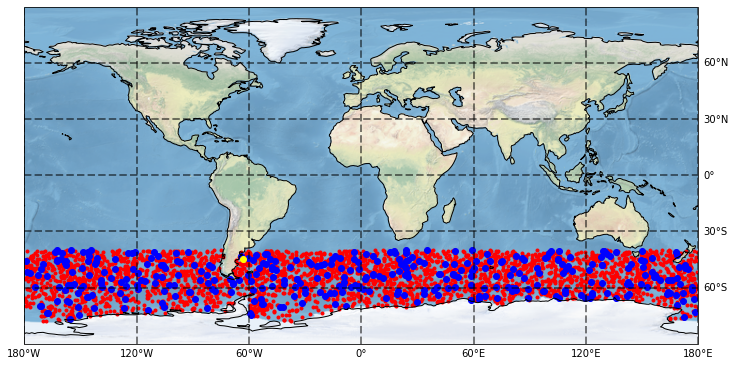

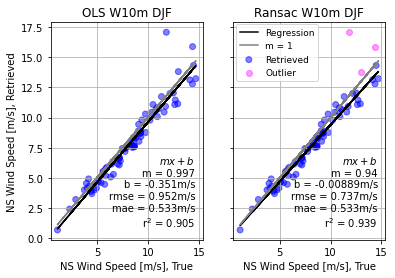

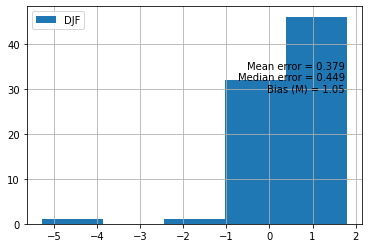

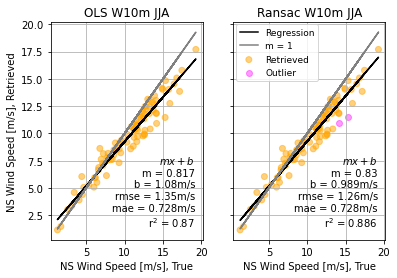

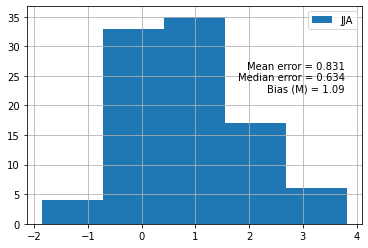

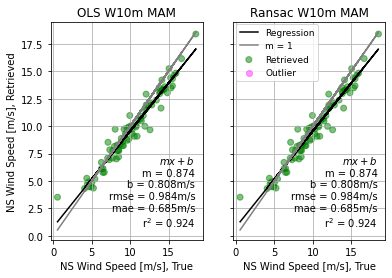

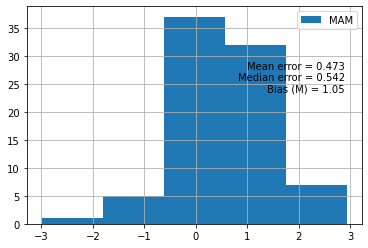

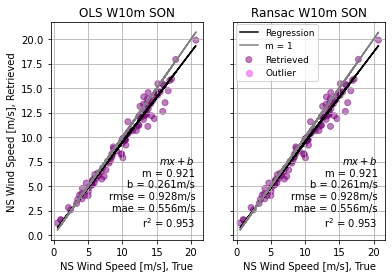

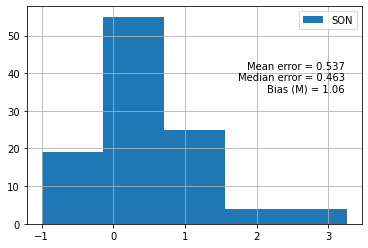

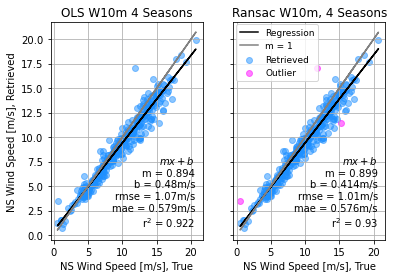

NO CONVERGENCE points:
1
NO CONVERGENCE points:
1
RMSE:
1.286215667154919
MAE:
0.688446559538164
R2:
1.005814548508745
346.90 s , Time: 


In [26]:
startTimeFold = time.time() # keep track of execution time

KK = 0

for indexTest in hh: 
    
    KK += 1
# How many "situations" do we want to test 
# (these will be split apart from the a-priori dataset).
# Situation means a (Lat, Long, time) combination:
# i.e. 1 Situation is one datapoint from the prior_local dataset
    nTestSamples = len(indexTest) 

# The test indices are deleted from the a-priori (i.e. training) set
    indexTrain = np.delete(indexTotal,indexTest)

# Split available diverse datasets into:
# - 5 profiles to generate synthetic data (profiles)
# - Rest of the profiles to generate the prior 
# The 5 profiles for synthetic data are EXCLUDED from
# the rest of the datasets (e.g. from the prior)

    profiles = prior_local.isel(time=indexTest) # For synthetic data
    prior_local_1 = prior_local.isel(time=indexTrain)  # For apriori data
    
    # Number of levels of profile-like variables: (137 in this example)
    nLev = len(prior_local_1.height)
    
    # Splitting the priors per season:
    priors, pressure, seasons, months, h_season = \
        supporting_routines_m.priors2seasons(prior_local_1) 
    

    flavor = 2 # check "priors2Pandas"
    
    # In short, flavor defines which variables from the dataset 
    # (temp, hum, wind speed, etc.) are going to be retrieved 
    # (i.e. x, state vector) and which variables are part of 
    # the parameters for the forward model (i.e. b, parameters vector).
    
    # For this simple example I defined 4 flavors 
    # (see other flavors definition in "support/priors2Pandas"). 
    
    # Flavor 2 means: retrieve wind speed components and skin temperature
    # Here in this excercise we assume that: 
    # surface temperature and skin temperature are the same thing! (not true)
    
    prior_xa, prior_b = \
        supporting_routines_m.priors2Pandas(
                    priors, flavor = flavor, h_season = h_season) 

    # For state vector variables:
    # Compute the means and covariance matrices 
    x_cov, x_mean = supporting_routines_m.meanCov(prior_xa, seasons)
    
    # Assert invertibility of the convariance matrices:
    for season in x_cov.season:
        assert np.linalg.matrix_rank(
            x_cov.sel(season=season).to_pandas()) ==  x_cov.shape[-1]
        
    # Definition of the state variables (e.g. names of the variables)
    x_vars = x_mean.state.values
 
    # For parameters:
    # Compute the means and covariance matrices 
    b_cov, b_mean = supporting_routines_m.meanCov(prior_b, seasons)
    
    # Assert invertibility of the convariance matrices:
    for season in x_cov.season:
        assert np.linalg.matrix_rank(
            b_cov.sel(season=season).to_pandas()) ==  b_cov.shape[-1]   
    
    # Definition of the parameters (e.g. names of the variables)
    b_vars = b_mean.state.values

        
    # Create x_truths: Pandas version of the profiles array 
    x_truths = supporting_routines_m.createTrueState(profiles, flavor=flavor)
    
    
    w_op2 = np.empty(0)
    w_op_err2 = np.empty(0)
    w_truth2 = np.empty(0)
    u_op2 = np.empty(0)
    u_op_err2 = np.empty(0)
    u_truth2 = np.empty(0)
    v_op2 = np.empty(0)
    v_op_err2 = np.empty(0)
    v_truth2 = np.empty(0)    
    lat_local = np.empty(0)
    long_local = np.empty(0)
    lat_skip = np.empty(0)
    long_skip = np.empty(0)
    seasonal = np.empty(0,dtype=object)
        
    count_breaks = 0
    count_nc = 0
    
    for ind in np.arange(len(indexTest)):

        startTimeRest1 = time.time() # keep track of execution time
        
        prof = profiles.time.values[ind] 
        seasonIndex = int(np.where(
                            np.isin(
                                months,profiles['time.month'].values[ind]))[0])
        season_prof = seasons[seasonIndex]

        # Profile used for generating synthetic observation:

        x_truth = x_truths.iloc[ind]

        Pressure = pressure.loc[season_prof,:].values[:] 

        # Other parameters needed for the radiative transfer model (RTTOV)
        lat1 = np.float64(profiles.lat.values[ind])
        long1 = np.float64(profiles.long.values[ind])
        datetime_obs = prof
        zenithAngle = 53.0 # Harcoded incidence angle for SSMIS
        salinity = 35      # Harcoded salinity of sea water

        # Create instance of Profiles class; 
        # it's a container of the input atmospheric state that RTTOV will simulate

        myProfiles = pyrttov.Profiles(nprofiles, nlevels)
        
        # forward_b_init fills "myProfiles" with the "fixed" parameters for the RTTOV simulation.
        # The forward model F(x,b), RTTOV in our case, has two "parameters": x and b
        # x is the state vector that is being retrieved (as such it is allowed to change during the retrieval)
        # b contains all other parameters that are fixed during the retrieval (everything else that is not being retrieved)

        forward_b_init(Pressure, salinity, 
              lat1, long1, datetime_obs, zenithAngle, myProfiles)
        
        # Define dictionary of parameters for the forward model:
        forwardKwArgs = {"myProfiles_a" : myProfiles, 
                         "ssmiRttov_a" : ssmiRttov}
    
        # Define a-priori information: mean and covariance matrix
        # for a given season (DJF, MAM, JJA, SON)

        x_a = x_mean.sel(season=season_prof).to_pandas()[x_vars]
        S_a = x_cov.sel(season=season_prof).to_pandas().loc[x_vars, x_vars]
        
        # Vector of parameters and its covariance:
        b_p = b_mean.sel(season=season_prof).to_pandas()[b_vars]
        S_b = b_cov.sel(season=season_prof).to_pandas().loc[b_vars, b_vars]
    
        
        # Call the forward model (i.e. creating synthetic obs.):

        y_obs = forwardRT(x_truth, **forwardKwArgs)
        y_obs = pd.Series(y_obs, index=y_vars)
        assert np.all(np.isfinite(y_obs))
        
        # Create optimalEstimation instance:

        oe_ref = pyOE.optimalEstimation( 
            x_vars, # state variable names
            x_a,  # a priori
            S_a, # a priori uncertainty
            y_vars,  # measurement variable names
            y_obs, # observations
            S_y, # observation uncertainty
            forwardRT, # forward Operator
            userJacobian=rttovK,  # RTTOV's K model operator
            forwardKwArgs=forwardKwArgs, # additonal function arguments
            #multipleForwardKwArgs=forwardKwArgsM, # additonal function arguments for jacobian tests
            x_truth=x_truth, # true profile
            b_vars=b_vars,   # Parameter vector variable names
            b_p=b_p,        # Parameter vector 
            S_b=S_b,        # Parameters error covariance matrix 
            #perturbation=0.01, # finite difference
            verbose=False
        )

        oe_ref.doRetrieval()
        
        if not oe_ref.converged : 
            count_nc += 1
            print('NO CONVERGENCE points:')
            print(count_nc)
            lat_skip = np.append(lat_skip,lat1)
            long_skip = np.append(long_skip,long1)
            continue

        _,_,u_op1, v_op1,_,_,_ = supporting_routines_m.splitX_all(oe_ref.x_op)
        _,_,u_op_err1, v_op_err1,_,_,_ = supporting_routines_m.splitX_all(oe_ref.x_op_err)

        _,_,u_truth1, v_truth1,_,_,_ = supporting_routines_m.splitX_all(oe_ref.x_truth)
        u_op2 = np.append(u_op2,u_op1)
        u_op_err2 = np.append(u_op_err2,u_op_err1)
        u_truth2 = np.append(u_truth2,u_truth1)
        v_op2 = np.append(v_op2,v_op1)
        v_op_err2 = np.append(v_op_err2,v_op_err1)
        v_truth2 = np.append(v_truth2,v_truth1)   
        
        # Uncertainty propagation and wind speed computation:
        w_op1, w_op_err1 = supporting_routines_m.UV2Wvar(oe_ref.S_op.loc['00010_nu','00010_nu'],
                                                  oe_ref.S_op.loc['00010_nv','00010_nv'],
                                                  oe_ref.S_op.loc['00010_nu','00010_nv'],
                                                  u_op1,v_op1)        

        # From the true profile, for comparison purposes: 
        w_truth1 = np.sqrt( u_truth1**2 + v_truth1**2 )   
        
        
        # We keep track of the results in this fold for plotting later:

        w_op2 = np.append(w_op2,w_op1)
        w_op_err2 = np.append(w_op_err2,w_op_err1)
        w_truth2 = np.append(w_truth2,w_truth1)
    
        seasonal = np.append(seasonal,season_prof)
        
        lat_local = np.append(lat_local,lat1)
        long_local = np.append(long_local,long1)
  
    
    # plot for some only (you can plot all if you want)
    if((KK==2)):
        
        # Show locations of analyzed data on map:
        plotInMap(lat_local, long_local, lat, long, KK, lat_skip, long_skip)
        
        #
        perSeasonPlots(w_truth2, w_op2, seasonal, KK, windType = 'W10m')
        #perSeasonPlots(u_truth2, u_op2, seasonal, KK, windType = 'U10m')
        #perSeasonPlots(v_truth2, v_op2, seasonal, KK, windType = 'V10m')
    
        _, _, _ = regressPlots(w_truth2, w_op2, KK, windType = 'W10m')   
        #_, _, _ = regressPlots(u_truth2, u_op2, KK, windType = 'U10m')
        #_, _, _ = regressPlots(v_truth2, v_op2, KK, windType = 'V10m')
  
    rmse_local, mae_local, r2_local = getSomeMetrics(w_truth2, w_op2)    
    rmse += rmse_local
    mae += mae_local
    r2 += r2_local
    
# Print some metrics in output:
rmse = rmse / KK
mae = mae / KK
r2 = r2 / KK
print('RMSE:')
print(rmse)
print('MAE:')
print(mae)
print('R2:')
print(r2)
print("%.2f s , Time: " % (time.time()-startTimeFold)) 